In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import matplotlib as mpl
import sys
import powerbox as pbox

from nbodykit.lab import *

from colossus.cosmology import cosmology
cosmo_c = cosmology.setCosmology('planck15')

In [2]:
def measure_autopk(array,L):
    mesh = ArrayMesh(array,BoxSize=L)
    r = FFTPower(mesh, mode='1d')
    return r.power

In [3]:
def noise(nc):
    np.random.seed(0)
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    b = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    return a + 1j * b

In [4]:
L=512
nc=256
wn = noise(nc)
a = measure_autopk(wn,L)

[]

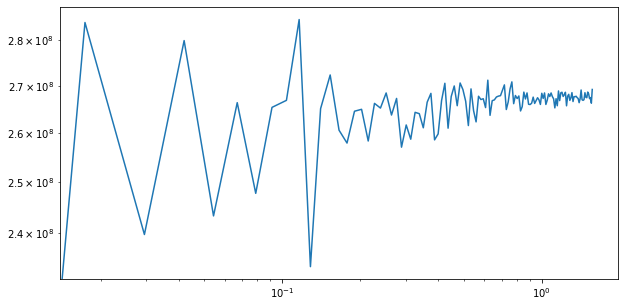

In [5]:
plt.figure(figsize=(10,5))
plt.plot(a['k'].real,a['power'].real)
plt.loglog()

In [6]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)

In [7]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return (np.sqrt(k2.astype(np.float16)))

In [8]:
kbox = k_box(nc,L)

In [9]:
"""
def pk(kval):
    return np.interp(kval,k,p)
pb = pbox.PowerBox(N=nc,dim=3,pk=pk,boxlength=L)
wnpkbox = pb.delta_x()
"""

'\ndef pk(kval):\n    return np.interp(kval,k,p)\npb = pbox.PowerBox(N=nc,dim=3,pk=pk,boxlength=L)\nwnpkbox = pb.delta_x()\n'

In [10]:
Pk_box = np.interp(kbox,k,p)

In [11]:
wnpk = wn *np.sqrt(Pk_box/L**(3)*nc**(6))
a1 = np.fft.ifftn(wnpk)

In [12]:
b1 = measure_autopk(a1.real,L)
#b3 = measure_autopk(wnpkbox.real,L)

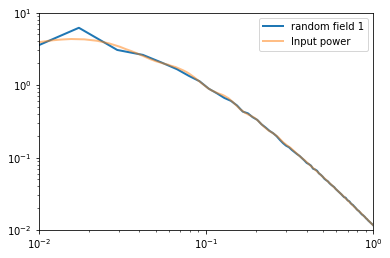

In [13]:
plt.plot(b1['k'].real,b1['power'].real,lw=2,label="random field 1")
#plt.plot(b3['k'].real,b3['power'].real,lw=2,label="random field 3")

plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,1)
plt.ylim(1E-2,1E1)
plt.legend()

In [269]:
def plot_slice(a1,start):
    cmap = plt.get_cmap('jet')
    start = start
    num=1
    end = start+num
    c= a1[:,start:end,:].mean(axis=1)
    c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    im = plt.imshow((c.T),interpolation='bilinear',origin='lower',aspect='auto',cmap=cmap)
    ax.set_aspect('equal')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="2%")
    cb = plt.colorbar(im,orientation='vertical',cax=cax)
    cb.ax.get_yaxis().labelpad = 0.
    plt.show()

In [15]:
#plot_slice(wnpkbox.real,int(nc/2))

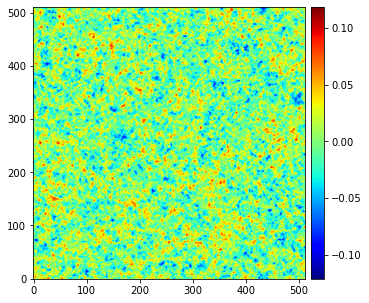

In [16]:
plot_slice(a1.real,int(nc/2))

In [17]:
"""Augment resolution in Fourier space"""
nc2 = 2*nc
kbox2 = k_box(nc2,L)
Pk_box2 = np.interp(kbox2,k,p)

In [18]:
wn2 = noise(nc2)
wnpk2 = wn2 * np.sqrt(Pk_box2/L**(3)*(nc2)**(6))
a2 = np.fft.ifftn(wnpk2)

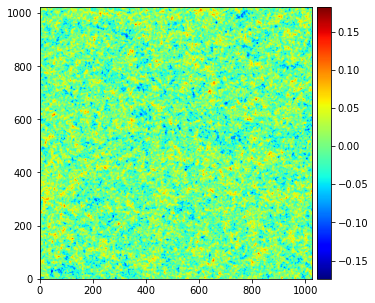

In [19]:
plot_slice(a2.real,int(nc2/2))

In [20]:
b2 = measure_autopk(a2.real,L)

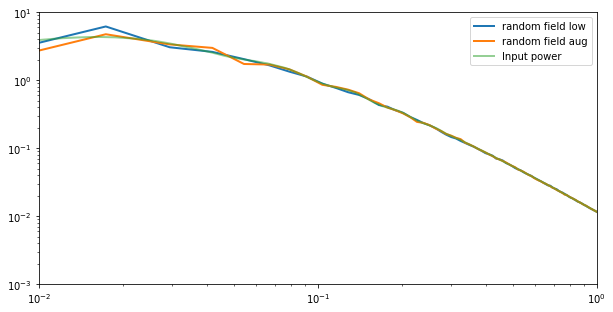

In [21]:
plt.figure(figsize=(10,5))
plt.plot(b1['k'].real,b1['power'].real,lw=2,label="random field low")
plt.plot(b2['k'].real,b2['power'].real,lw=2,label="random field aug")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,1)
plt.ylim(1E-3,1E1)
plt.legend()

In [22]:
"""Create k^2 in box (nc x nc x nc)"""
def k_ind_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc),dtype=np.float32).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    return (a.astype(np.float16))

In [23]:
kfac = 2.*np.pi/L

In [24]:
kboxindt =  k_ind_box(2,L)

In [25]:
kboxindt2 =  k_ind_box(4,L)

In [26]:
iindt = np.isin(kboxindt2,kboxindt)

In [27]:
iindt.all(axis=-1).shape

(4, 4, 4)

In [28]:
kboxindt.shape

(2, 2, 2, 3)

In [29]:
kboxindt2[iindt.all(axis=-1)]=kboxindt.reshape(8,3)*10.

In [331]:
delta_lin = np.fromfile('deltaLOGN_1000.dat',dtype=np.float32).reshape(nc,nc,nc)
delta_lin[120:130,120:130,120:130]=+0.7
delta_lin[60:70,120:130,60:70]=+0.7
delta_lin[200:210,120:130,200:210]=+0.7
delta_lin[60:70,120:130,200:210]=+0.7
delta_lin[200:210,120:130,60:70]=+0.7

In [332]:
pk_delta = measure_autopk(delta_lin,L)

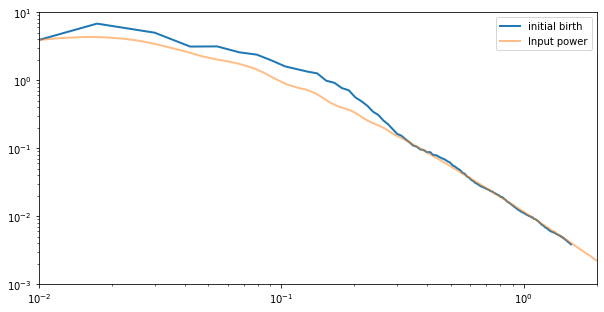

In [333]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="initial birth")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,2)
plt.ylim(1E-3,1E1)
plt.legend()

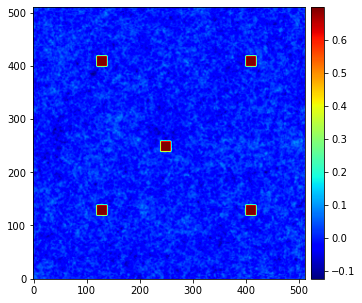

In [334]:
plot_slice(delta_lin,int(nc/2))

In [134]:
grf2 = np.fft.ifftn(wnpk2).real

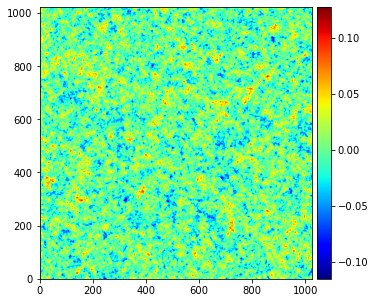

In [135]:
plot_slice(grf2,int(nc2/2))

In [36]:
kboxind =  k_ind_box(nc,L)

In [37]:
kboxind2 =  k_ind_box(nc2,L)

In [38]:
iind = np.isin(kboxind2,kboxind)
ii = iind.all(axis=-1)

In [345]:
delta_k = np.fft.fftn(delta_lin)
#delta_k = np.fft.fftshift(delta_k)

In [40]:
wnpk2c = np.copy(wnpk2)
#wnpk2c = np.fft.fftshift(wnpk2c)

In [41]:
wnpk2c[ii]=delta_k.ravel()*8 #*np.sqrt(nc**(6)/L**(3))

In [42]:
grf2c = np.fft.ifftn(wnpk2c)

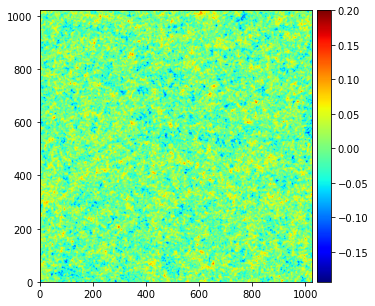

In [43]:
plot_slice(grf2c.real,int(nc2/2))

In [44]:
pk_delta = measure_autopk(grf2c,L)

In [45]:
np.where(ii==True)[0].shape

(16777216,)

In [46]:
wnpk2[ii]=0

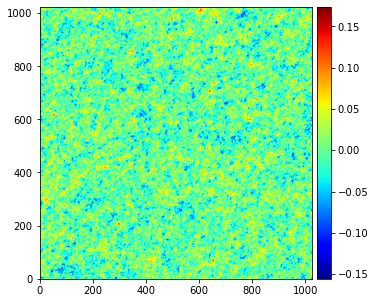

In [47]:
grf2 = np.fft.ifftn(wnpk2)
plot_slice(grf2.real,int(nc2/2))

In [48]:
aa = k_ind_box(2,L)

In [49]:
bb = k_ind_box(4,L)

In [50]:
delta_test = np.fromfile('HRwhite_noise_cosmos_1200.dat',dtype=np.float32).reshape(nc2,nc2,nc2)

In [51]:
nc2 = 2*nc
kbox2 = k_box(nc2,L)
Pk_box2 = np.interp(kbox2,k,p)
wn2 = noise(nc2)
wnpk2 = wn2 * np.sqrt(Pk_box2/L**(3)*(nc2)**(6))
grf2 = np.fft.ifftn(wnpk2).real

In [52]:
pk_delta = measure_autopk(a2.real,L)

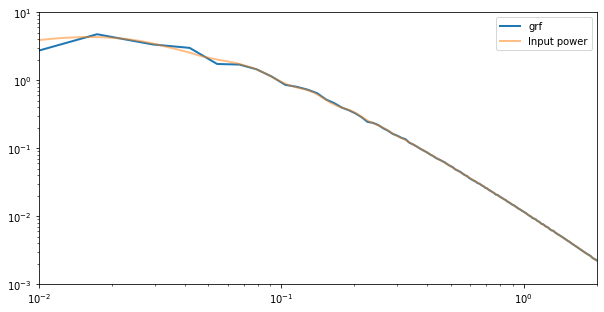

In [53]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="grf")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,2)
plt.ylim(1E-3,1E1)
plt.legend()

In [136]:
wnpk2c = np.copy(wnpk2)

In [137]:
wnpk2c[ii].real=delta_k.ravel().real*8

In [138]:
wnpk2c[ii].imag=delta_k.ravel().imag*8

In [139]:
grf2c = np.fft.ifftn(wnpk2c)

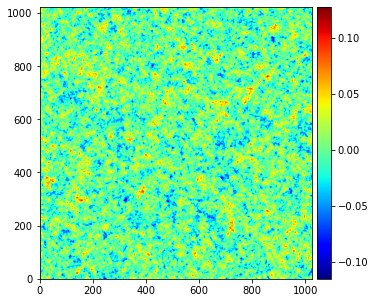

In [140]:
plot_slice(grf2c.real,int(nc2/2))

In [346]:
t = np.zeros((nc2,nc2,nc2),dtype=np.complex64)

In [347]:
t[ii]=delta_k.ravel()*8

In [348]:
t[np.invert(ii)]=wnpk2c[np.invert(ii)]

In [349]:
tr = np.fft.ifftn(t)

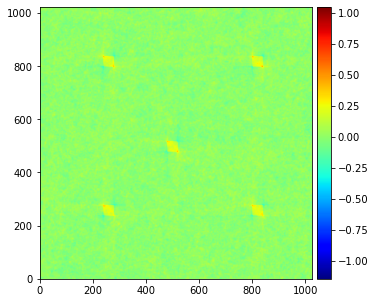

In [350]:
plot_slice(tr.real,int(nc2/2))

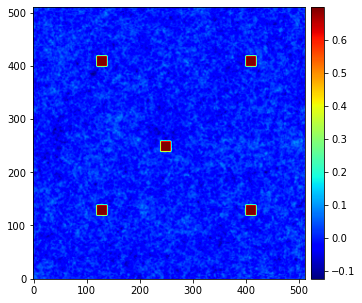

In [351]:
plot_slice(delta_lin.real,int(nc/2))

In [355]:
pk_delta = measure_autopk(tr.real,L)

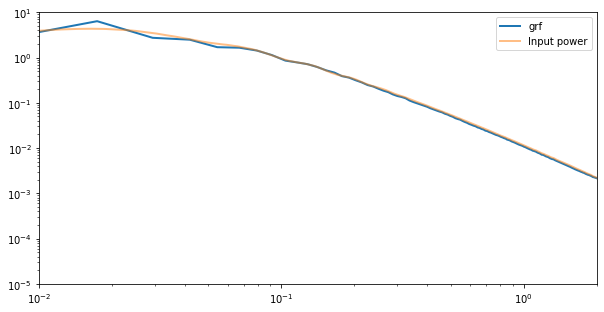

In [356]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="grf")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,2)
plt.ylim(1E-5,1E1)
plt.legend()

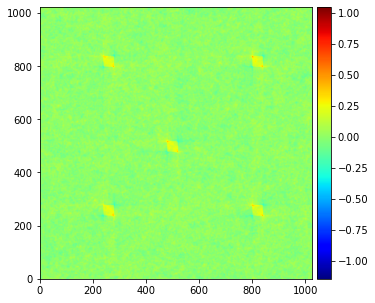

In [357]:
plot_slice(tr.real.T,int(nc2/2))

In [431]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)

In [442]:
p[2500:2700] = 30
p[3055:3300] = 15
p[3555:3900] = 0.5


In [443]:
Pk_boxtest = np.interp(kbox,k,p)

In [461]:
wnpk = wn *np.sqrt(Pk_boxtest/L**(3)*nc**(6))


In [445]:
a1 = np.fft.ifftn(wnpk)
b1 = measure_autopk(a1.real,L)


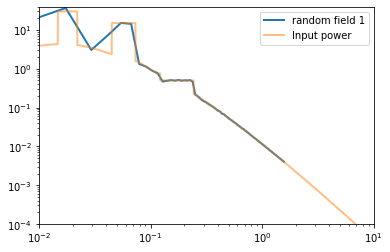

In [464]:
plt.plot(b1['k'].real,b1['power'].real,lw=2,label="random field 1")
#plt.plot(b3['k'].real,b3['power'].real,lw=2,label="random field 3")

plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,10)
plt.ylim(1E-4,4E1)
plt.legend()

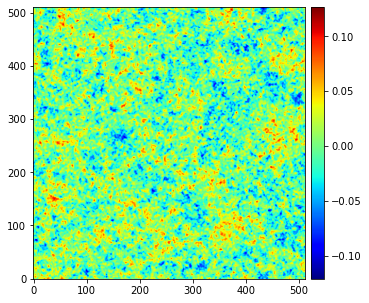

In [465]:
plot_slice(a1.real,int(nc/2))

In [ ]:
t = np.zeros((nc2,nc2,nc2),dtype=np.complex64)
t[ii]=wnpk.ravel()*4
t[np.invert(ii)]=wnpk2c[np.invert(ii)]
tr = np.fft.ifftn(t)
pk_delta = measure_autopk(tr.real,L)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="grf")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,40)
plt.ylim(1E-5,4E1)
plt.legend()

In [ ]:
plot_slice(tr.real,int(nc2/2))

In [ ]:
plot_slice(a1.real,int(nc/2))